In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.interpolate import griddata

# Calculating grid magnetic field in Colombia

# This project magnetic field calculator. It uses is British Geological Survey (BGS) API web service for calculation.

The web service makes the World Magnetic Model (WMM), the International Geomagnetic Reference Field (IGRF) and the BGS Global Geomagnetic Model (BGGM) available as a web service. The IGRF and WMM have no restrictions on use, the BGGM is only available to subscribers. The API provides options to select which model and revision to use. Values of the magnetic field at any point around the world can be retrieved for a given date. https://pypi.org/project/magnetic-field-calculator/

In [11]:
from magnetic_field_calculator import MagneticFieldCalculator

In [3]:
calculator=MagneticFieldCalculator()

In [4]:
calculator.calculate(latitude=4.22,longitude=-73.12,altitude=630)['field-value']['total-intensity']['value']

22524

# Reading SRTM data with Python
Digital Elevation Model (DEM) provides elevation data for use in programs and analysis. These models have varied practical uses like line-of-sight and viewshed analysis. Shuttle Radar Topography Mission (SRTM), as the name suggests, is a research mission to produce a free DEM for general use. If you are like me, you hadn't heard about DEM before you actually had to use it. And, you will be amazed where they are being used. https://librenepal.com/article/reading-srtm-data-with-python/

## File Name
SRTM data file has a .hgt extension (a shortform for height ?) and its name defines its coverage. For example, a filename named N26E092.hgt contains elevation data that stretches from 26°N 92°E to 27°N 93°E

## Data is available from:
http://www.viewfinderpanoramas.org/Coverage%20map%20viewfinderpanoramas_org3.htm

In [5]:
import os
import json
import numpy as np

SAMPLES = 1201  # Change this to 3601 for SRTM1
HGTDIR = 'hgt'  # All 'hgt' files will be kept here uncompressed


def get_elevation(lon, lat):
    hgt_file = get_file_name(lon, lat)
    if hgt_file:
        return read_elevation_from_file(hgt_file, lon, lat)
    # Treat it as data void as in SRTM documentation
    # if file is absent
    return 0


def read_elevation_from_file(hgt_file, lon, lat):
    with open(hgt_file, 'rb') as hgt_data:
        # HGT is 16bit signed integer(i2) - big endian(>)
        elevations = np.fromfile(hgt_data, np.dtype('>i2'), SAMPLES*SAMPLES)\
                                .reshape((SAMPLES, SAMPLES))

        lat_row = int(round((lat - int(lat)) * (SAMPLES - 1), 0))
        lon_row = int(round((lon - int(lon)) * (SAMPLES - 1), 0))

        return elevations[SAMPLES - 1 - lat_row, lon_row].astype(int)

def get_file_name(lon, lat):
    """
    Returns filename such as N27E086.hgt, concatenated
    with HGTDIR where these 'hgt' files are kept
    """

    if lat >= 0:
        ns = 'N'
    elif lat < 0:
        ns = 'S'

    if lon >= 0:
        ew = 'E'
    elif lon < 0:
        ew = 'W'

    hgt_file = "%(ns)s%(lat)02d%(ew)s%(lon)03d.hgt" % {'lat': abs(lat), 'lon': abs(lon), 'ns': ns, 'ew': ew}
    hgt_file_path = os.path.join(HGTDIR, hgt_file)
    if os.path.isfile(hgt_file_path):
        return hgt_file_path
    else:
        return None

# Mt. Everest
print(get_elevation(-73.2, 4.36))
# Kanchanjunga
print(get_elevation(88.146667, 27.7025))

169
0


In [6]:
Npoints=50
lon,lat=np.linspace(-80,-66,Npoints),np.linspace(4,12,Npoints)

In [7]:
LAT,LON,ALT=[],[],[]
for i, j in list(itertools.product(lon, lat)):
    #print(i,j,get_elevation(i, j))
    LAT.append(j)
    LON.append(i)
    ALT.append(get_elevation(i, j))
LAT,LON,ALT=np.array(LAT),np.array(LON),np.array(ALT)

In [8]:
FIELD=[]
for i, j, k in zip(LON, LAT, ALT):
    FIELD.append(calculator.calculate(latitude=j,longitude=i,altitude=k)['field-value']['total-intensity']['value'])
FIELD=np.array(FIELD)

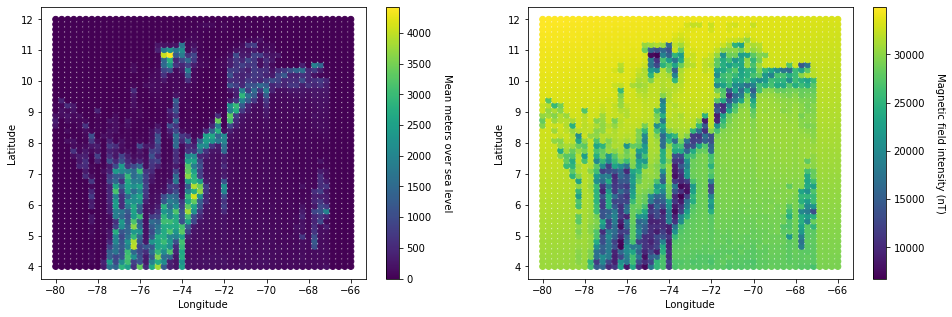

In [16]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.scatter(LON,LAT,c=ALT)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
cbar = plt.colorbar()
cbar.set_label('Mean meters over sea level', rotation=270, labelpad=20)
plt.subplot(122)
plt.scatter(LON,LAT,c=FIELD)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
cbar = plt.colorbar()
cbar.set_label('Magnetic field intensity (nT)', rotation=270, labelpad=20)
plt.show()

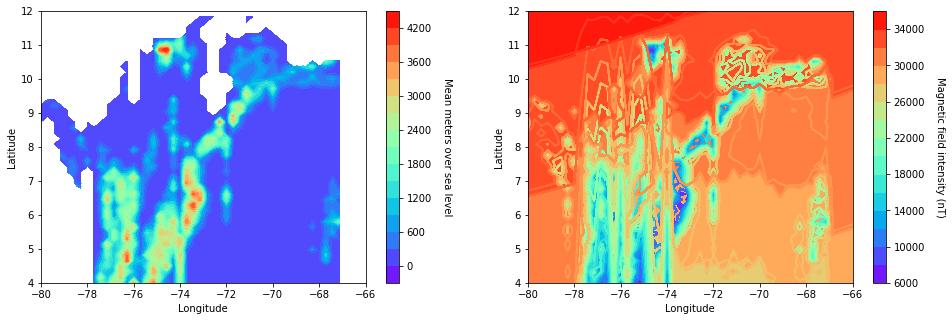

In [17]:
plt.figure(figsize=(16,5))

# Interpolate for plotting
plt.subplot(121)
zi = griddata((LON, LAT), ALT, (LON[None,:], LAT[:,None]), method='cubic')
zi[zi==0] = np.nan
# Create the contour plot
CS2 = plt.contour(LON, LAT, zi, 15, cmap=plt.cm.rainbow)
CS = plt.contourf(LON, LAT, zi, 15, cmap=plt.cm.rainbow)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
cbar = plt.colorbar()
cbar.set_label('Mean meters over sea level', rotation=270, labelpad=20)
plt.subplot(122)
wi = griddata((LON, LAT), FIELD, (LON[None,:], LAT[:,None]), method='cubic')
wi[wi==0] = np.nan
# Create the contour plot
CS2 = plt.contour(LON, LAT, wi, 15, cmap=plt.cm.rainbow)
CS = plt.contourf(LON, LAT, wi, 15, cmap=plt.cm.rainbow)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
cbar = plt.colorbar()
cbar.set_label('Magnetic field intensity (nT)', rotation=270, labelpad=20)
plt.show()